In [1]:
# Data management
import pandas as pd
import json
from pandas.io.json import json_normalize
from pandas.plotting import scatter_matrix
from datetime import datetime

# Math and Stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Data preprocessing and trasformation (ETL)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification

# Supervised Learning
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
# date unix conversion
def date_f(unix_d):
    d = datetime.utcfromtimestamp(unix_d).strftime('%Y-%m-%d %H:%M:%S')
    d1 = datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    return d1

# cross-validation model
def valuta_modello(X, y, model, n_splits=10, shuffle=True):
    # non avendo comunque un grande sbilanciamento procedo solo con la StratifiedKfold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    s = ['accuracy', 'precision', 'recall', 'f1']
    print('\n {}'.format(skf))
    scores = cross_validate(model, X, y, scoring=s, cv=skf, n_jobs=-1)
    y_train_predicted = cross_val_predict(model, X, y, cv=skf)
    for j in s:
        print('>scoring={} mean={:.4f} se={:.3f}'.format(j, np.mean(scores[('test_'+ j)]), sem(scores[('test_'+ j)])))
    print('\n confusion matrix \n {}'.format(confusion_matrix(y, y_train_predicted)))

# embedding sentences
def embedding_text(t, model):
    blurb_l = t.values.tolist()
    sentence_embeddings = np.asmatrix(model(blurb_l).numpy())
    return sentence_embeddings

## Caricamento dataset e selezione features

In [3]:
data = [json.loads(line) for line in open('data3/Kickstarter_2021-01-14T03_20_05_328Z.json', 'r', encoding="utf8")]
data = pd.json_normalize(data)

In [4]:
# keep only the useful columns
ks = data.iloc[: , [3, 13, 14, 15, 17, 25, 28, 32, 59, 64, 68]]

# rename columns
ks = ks.rename(lambda x: x.replace(".", "_"), axis=1)
ks = ks.rename(lambda x: x.replace("data_", ""), axis=1)

# remove records in the columns 'state' with value 'live' and 'canceled'
ks = ks[ks.state != 'live']
ks = ks[ks.state != 'canceled']

# remove records in the columns 'id' with value duplicate
ks = ks.drop_duplicates('id')

# conversion of unix date
ks['deadline'] = ks['deadline'].apply(date_f)
ks['launched_at'] = ks['launched_at'].apply(date_f)

# create a column with only the days relating to the funding period
ks['funding_period'] = (ks['deadline']-ks['launched_at']).dt.days

# create two columns with only the months related to the date of columns 'deadline' and 'launched_at'
ks['deadline_month'] = ks['deadline'].dt.month
ks['launched_at_month'] = ks['launched_at'].dt.month

# conversion of the 'goal' currency in USD
ks['goal'] = ks['goal']*ks['static_usd_rate']

# create two columns with the length of value in the columns 'name' and 'blurb'
ks['name_l'] = ks['name'].str.len()
ks['blurb_l'] = ks['blurb'].str.len()

# remove the null values from the column 'location_expanded_country' and reset the index
ks.dropna(subset=['location_expanded_country'], inplace=True)
ks.dropna(subset=['category_parent_name'], inplace=True)
ks = ks.reset_index(drop=True)

In [5]:
# extract the label column and remove it from the dataset along with non-useful columns
ks_label1 = ks['state'].map(
    {'failed':0,
     'successful':1
    }
)
ks1 = ks.drop(['id', 'name', 'blurb', 'state', 'deadline', 'launched_at', 'static_usd_rate'], axis=1)

In [6]:
ks1.columns = ['goal', 'country', 'main_category', 'sec_category', 'funding_period', 'deadline_month', 'launched_month', 'name_l', 'descr_l']

In [7]:
ks1.head()

,goal,country,main_category,sec_category,funding_period,deadline_month,launched_month,name_l,descr_l
0,5227.00000,United States,Community Gardens,Food,29,4,3,29,123
1,46282.03230,United Kingdom,Drama,Film & Video,30,8,7,15,119
2,1000.00000,United States,Playing Cards,Games,30,7,6,55,133
3,1019.89432,Hong Kong,Playing Cards,Games,30,10,9,31,30
4,550.00000,United States,Textiles,Art,30,2,1,27,124


## Analisi dataset

In [8]:
print(ks_label1.value_counts())
print(ks_label1.value_counts(normalize=True))

1    98965
0    75032
Name: state, dtype: int64
1    0.568774
0    0.431226
Name: state, dtype: float64


In [9]:
ks1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173997 entries, 0 to 173996
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   goal            173997 non-null  float64
 1   country         173997 non-null  object 
 2   main_category   173997 non-null  object 
 3   sec_category    173997 non-null  object 
 4   funding_period  173997 non-null  int64  
 5   deadline_month  173997 non-null  int64  
 6   launched_month  173997 non-null  int64  
 7   name_l          173997 non-null  int64  
 8   descr_l         173997 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 11.9+ MB


In [10]:
ks1.describe()

,goal,funding_period,deadline_month,launched_month,name_l,descr_l
count,1.739970e+05,173997.000000,173997.000000,173997.000000,173997.000000,173997.000000
mean,4.069380e+04,32.830445,6.807727,6.495066,34.576700,108.773105
std,1.126513e+06,12.123884,3.352057,3.324701,15.616727,29.417966
min,1.000000e-02,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.500000e+03,29.000000,4.000000,4.000000,21.000000,94.000000
50%,5.000000e+03,30.000000,7.000000,7.000000,34.000000,121.000000
75%,1.280000e+04,35.000000,10.000000,9.000000,48.000000,132.000000
max,1.523501e+08,91.000000,12.000000,12.000000,85.000000,150.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018D0CC3E5E0>,
      dtype=object)

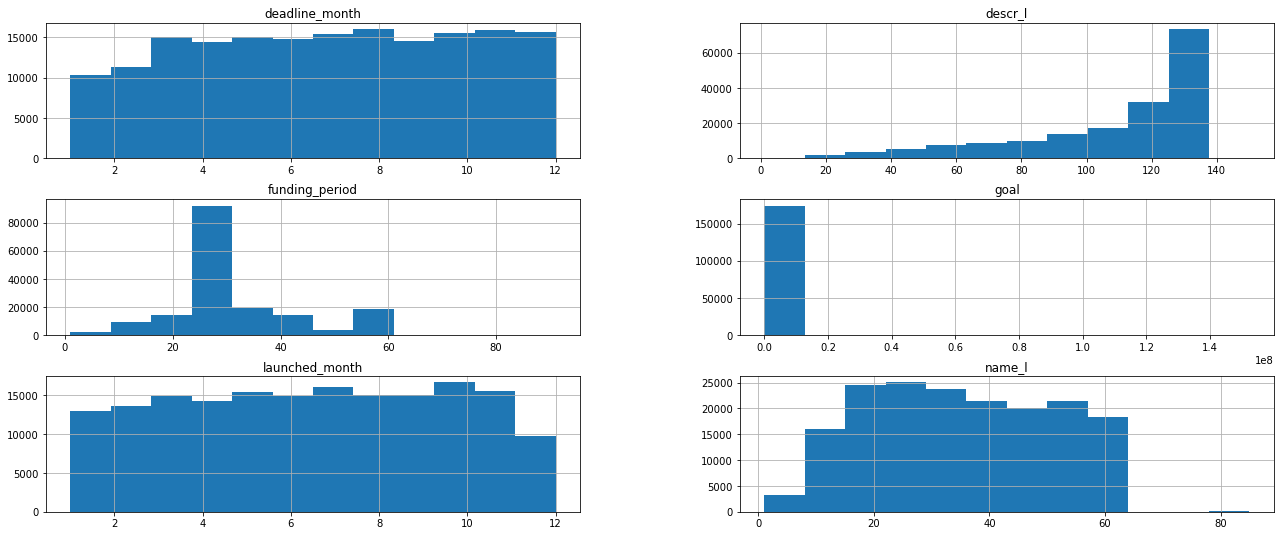

In [11]:
ks1.hist(figsize=(22,9), bins=12)

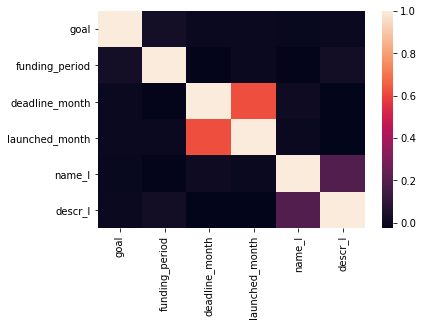

In [12]:
import seaborn as sns
corr = ks1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

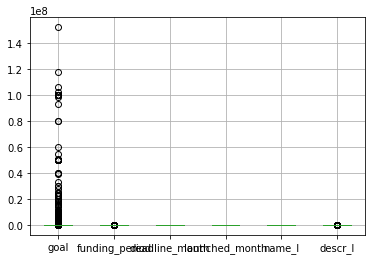

In [13]:
ks1.boxplot()

## Logistic Regression

In [7]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [8]:
def embedding_text(t):
    blurb_l = t.values.tolist()
    sentence_embeddings = np.asmatrix(model(blurb_l).numpy())
    return sentence_embeddings

In [9]:
# tengo solo i kickstarter che hanno una lingua inglese
ksNN = ks.loc[ks['location_expanded_country'].isin(['United States', 'United Kingdom', 'Canada'])]
ksNN = ksNN.reset_index(drop=True)
# Estraggo la  colonna delle label e la rimuovo dal dataset assieme a colonne non utili
ks_label_NN = ksNN['state'].map(
    {'failed':0,
     'successful':1
    }
)

# rinomino le colonne
ksNN.columns = ['id', 'name', 'blurb', 'goal', 'state', 'deadline', 'launched_at', 'static_usd_rate', 'country', 'main_category', 'sec_category', 'funding_period', 'deadline_month', 'launched_month', 'name_l', 'descr_l']
# embedding della descrizione 'blurb'
ksNN = pd.concat([ksNN, pd.DataFrame(embedding_text(ksNN['blurb']))], axis=1)
ksNN = ksNN.drop(['id', 'name', 'blurb', 'state', 'deadline', 'launched_at', 'static_usd_rate'], axis=1)

In [11]:
ksNN.head()

,goal,country,main_category,sec_category,funding_period,deadline_month,launched_month,name_l,descr_l,0,...,502,503,504,505,506,507,508,509,510,511
0,5227.0000,United States,Community Gardens,Food,29,4,3,29,123,-0.010829,...,-0.003118,-0.024705,-0.059358,0.056610,-0.089700,0.030305,-0.009304,-0.019028,0.018583,0.023158
1,46282.0323,United Kingdom,Drama,Film & Video,30,8,7,15,119,0.030061,...,0.043978,0.053403,0.002196,0.019149,0.072489,-0.006856,0.021633,-0.056170,0.021966,0.055888
2,1000.0000,United States,Playing Cards,Games,30,7,6,55,133,-0.044113,...,0.001915,0.001887,-0.033332,-0.049701,0.051441,0.033418,-0.039642,0.026644,-0.018060,0.010671
3,550.0000,United States,Textiles,Art,30,2,1,27,124,0.056926,...,-0.046150,0.063592,0.033569,0.033628,-0.049368,-0.049821,-0.072348,0.041021,0.019057,0.024530
4,20000.0000,United States,Mixed Media,Art,31,11,10,35,98,-0.024801,...,-0.006140,0.043791,-0.029727,-0.010970,0.030046,-0.064697,-0.008077,0.010609,0.072714,0.053714


In [10]:
features_categorical = ['country','main_category','sec_category', 'launched_month', 'deadline_month']
features_robust = ['descr_l','goal','funding_period']
features_standard = ['name_l']

In [11]:
data_preprocessing_NN = ColumnTransformer([
    ('features_categorical', OneHotEncoder(sparse=False), features_categorical),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)


In [12]:
fm2 = data_preprocessing_NN.fit_transform(ksNN)
print(type(fm2), fm2.shape)

<class 'numpy.ndarray'> (143802, 704)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(fm2, ks_label_NN, test_size=0.3, random_state=45)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100661, 704), (100661,), (43141, 704), (43141,))

### GridSearch

In [22]:
logit_cls = LogisticRegression(max_iter=1000, n_jobs=-1) 

In [23]:
param_grid_lr = [
    {'penalty': ['l1', 'l2'],
     'class_weight':['balanced', None],
     'solver':['liblinear', 'saga'],
     'C': [0.001, 0.01, 1, 100, 1000]
    }
]

grid_search_lr = GridSearchCV(logit_cls, 
                           param_grid= param_grid_lr,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [24]:
grid_search_lr.fit(X_train, y_train)

C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 1, 100, 1000],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='f1', scoring=['f1', 'accuracy'])

In [25]:
results = pd.DataFrame(grid_search_lr.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
20,0.811335,"{'C': 1, 'class_weight': None, 'penalty': 'l1'...",0.783213
22,0.811329,"{'C': 1, 'class_weight': None, 'penalty': 'l2'...",0.783054
28,0.810726,"{'C': 100, 'class_weight': None, 'penalty': 'l...",0.782269
36,0.810695,"{'C': 1000, 'class_weight': None, 'penalty': '...",0.782229
30,0.810683,"{'C': 100, 'class_weight': None, 'penalty': 'l...",0.782190
38,0.810632,"{'C': 1000, 'class_weight': None, 'penalty': '...",0.782160
14,0.810279,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.773080
18,0.792129,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.776150
24,0.791967,"{'C': 100, 'class_weight': 'balanced', 'penalt...",0.775673
26,0.791944,"{'C': 100, 'class_weight': 'balanced', 'penalt...",0.775683


In [26]:
print('best score: ',grid_search_lr.best_score_)
print('best params: ',grid_search_lr.best_params_)

best score:  0.8113354575831375
best params:  {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


### RandomizedSearch

In [27]:
param_grid_lr_r = [
    {'penalty': ['l1', 'l2'],
     'class_weight':['balanced', None],
     'solver':['liblinear', 'saga'],
     'C': [0.001, 0.01, 1, 100, 1000]
    }
]

random_search_lr = RandomizedSearchCV(logit_cls, 
                           param_distributions= param_grid_lr_r,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [28]:
random_search_lr.fit(X_train, y_train)

C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                   n_jobs=-1,
                   param_distributions=[{'C': [0.001, 0.01, 1, 100, 1000],
                                         'class_weight': ['balanced', None],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [29]:
results_r = pd.DataFrame(random_search_lr.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results_r.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
7,0.810730,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.782229
8,0.791927,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.775643
5,0.791553,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.775683
6,0.785825,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.721044
4,0.768499,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.732021
2,0.753384,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.660613
3,0.727231,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.645662
0,0.663240,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.621194
1,0.663240,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.621194
9,0.632702,"{'solver': 'saga', 'penalty': 'l1', 'class_wei...",0.600014


In [30]:
print('best score: ',random_search_lr.best_score_)
print('best params: ',random_search_lr.best_params_)

best score:  0.8107301446420163
best params:  {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 100}


### Validation best params

In [31]:
logit_cls_bp = LogisticRegression(max_iter=1000,
                                  n_jobs=-1,
                                  C=1,
                                  class_weight=None,
                                  penalty= 'l1',
                                  random_state=1,
                                  solver='liblinear') 

In [32]:
train_sizes, train_scores, test_scores = learning_curve(logit_cls_bp,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=StratifiedKFold(random_state=1, shuffle=True),
                                                       n_jobs=-1)

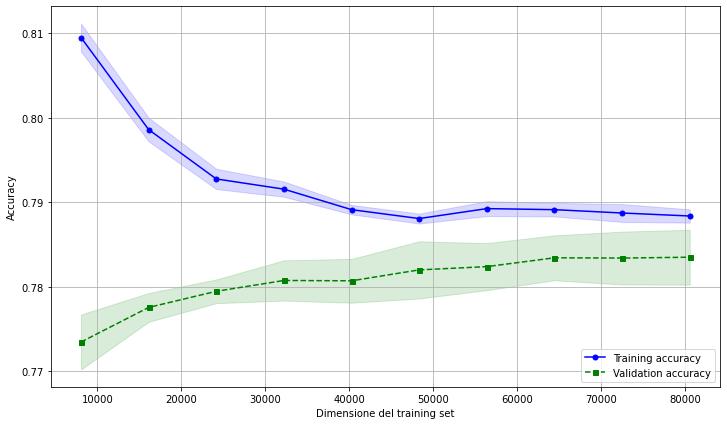

In [33]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')

In [34]:
print("accuracy:", round(train_mean[-1], 4), "- val_accuracy:", round(test_mean[-1], 4))

accuracy: 0.7884 - val_accuracy: 0.7835


C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

val_accuracy: 0.7835


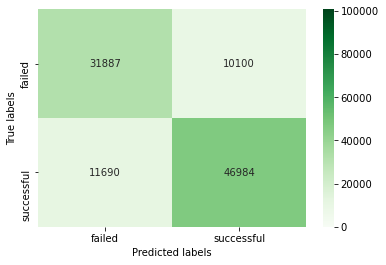

In [35]:
y_train_p_lr = cross_val_predict(logit_cls_bp, X_train, y_train, cv=StratifiedKFold(random_state=1, shuffle=True))
print('val_accuracy:', round(accuracy_score(y_train, y_train_p_lr), 4))

cm_c_lr = confusion_matrix(y_train, y_train_p_lr)
ax= plt.subplot()
sns.heatmap(cm_c_lr, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_lr)));
sns.heatmap(cm_c_lr, annot=cm_c_lr, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_lr)))

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

### Test result

In [36]:
logit_cls_bp.fit(X_train, y_train)

C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=1, max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='liblinear')

Accuracy SCore 0.782735680674996
F1 SCore 0.7832522157413354
Precision Score 0.784145252602204
Recall SCore 0.782735680674996


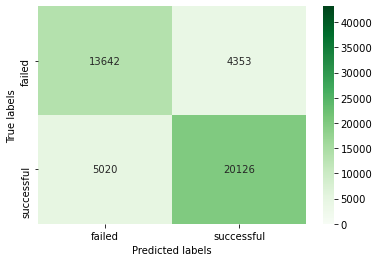

In [38]:
y_pred_lr = logit_cls_bp.predict(X_test)
print("Accuracy SCore", accuracy_score(y_test, y_pred_lr))
print("F1 SCore", f1_score(y_test, y_pred_lr, average='weighted'))
print("Precision Score", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall SCore", recall_score(y_test, y_pred_lr, average='weighted'))
cm = confusion_matrix(y_test, y_pred_lr)
ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm)));
sns.heatmap(cm, annot=cm, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm)))

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

## Neural network

In [13]:
def build_model(n_neurons1=300, n_neurons2=200, n_neurons3=100, n_neurons4=50, n_neurons5=10, optimizer='adam', loss='binary_crossentropy', input_shape=[704]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(n_neurons1, activation="relu"))
    model.add(keras.layers.Dense(n_neurons2, activation="relu"))
    model.add(keras.layers.Dense(n_neurons3, activation="relu"))
    model.add(keras.layers.Dense(n_neurons4, activation="relu"))
    model.add(keras.layers.Dense(n_neurons5, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss=loss, optimizer=optimizer,
                 metrics =  ['accuracy'])
    return model

In [14]:
X_trainNN, X_testNN, y_trainNN, y_testNN = train_test_split(fm2, ks_label_NN, test_size=0.3, random_state=45)
X_trainNN.shape, y_trainNN.shape, X_testNN.shape, y_testNN.shape

((100661, 704), (100661,), (43141, 704), (43141,))

### Randomized search

In [41]:
keras_NN = keras.wrappers.scikit_learn.KerasClassifier(build_model)

#### 1

In [42]:
param_grid_NN = [
    {"n_neurons1": [150, 300, 450],
     "n_neurons2": [100, 200, 300],
     "n_neurons3": [50, 100, 150],
     "n_neurons4": [25, 50, 75],
     "n_neurons5": [5, 10, 15],
     "optimizer": ['SGD', 'Adam', 'AdaDelta']     
    }
]

rand_search_NN = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [43]:
rand_search_NN.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000018CA91D64F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 300, 450],
                                         'n_neurons2': [100, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [44]:
print('best score: ',rand_search_NN.best_score_)
print('best params: ',rand_search_NN.best_params_)

best score:  0.8097694089840399
best params:  {'optimizer': 'SGD', 'n_neurons5': 10, 'n_neurons4': 50, 'n_neurons3': 50, 'n_neurons2': 300, 'n_neurons1': 150}


#### 2

In [45]:
rand_search_NN1 = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [46]:
rand_search_NN1.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000018CA91D64F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 300, 450],
                                         'n_neurons2': [100, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [47]:
print('best score: ',rand_search_NN1.best_score_)
print('best params: ',rand_search_NN1.best_params_)

best score:  0.8048338476587166
best params:  {'optimizer': 'Adam', 'n_neurons5': 5, 'n_neurons4': 75, 'n_neurons3': 50, 'n_neurons2': 300, 'n_neurons1': 450}


#### 3

In [48]:
param_grid_NN2 = [
    {"n_neurons1": [150, 200, 100],
     "n_neurons2": [400, 200, 300],
     "n_neurons3": [50, 100, 150],
     "n_neurons4": [25, 50, 75],
     "n_neurons5": [5, 10, 15],
     "optimizer": ['SGD', 'Adam', 'AdaDelta']     
    }
]

rand_search_NN2 = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN2,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [49]:
rand_search_NN2.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000018CA91D64F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 200, 100],
                                         'n_neurons2': [400, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [50]:
print('best score: ',rand_search_NN2.best_score_)
print('best params: ',rand_search_NN2.best_params_)

best score:  0.8120785474954897
best params:  {'optimizer': 'SGD', 'n_neurons5': 5, 'n_neurons4': 50, 'n_neurons3': 100, 'n_neurons2': 400, 'n_neurons1': 100}


### Utilizzo best_params

In [51]:
model_bp = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model_bp.compile(loss = 'binary_crossentropy',
              optimizer = 'SGD',
              metrics =  ['accuracy']
             )

history_bp = model_bp.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6563 - accuracy: 0.6055 - val_loss: 0.5776 - val_accuracy: 0.7018
Epoch 2/50
2202/2202 [==============================] - 3s 1ms/step - loss: 0.5371 - accuracy: 0.7273 - val_loss: 0.4673 - val_accuracy: 0.7632
Epoch 3/50
2202/2202 [==============================] - 3s 1ms/step - loss: 0.4650 - accuracy: 0.7641 - val_loss: 0.4406 - val_accuracy: 0.7763
Epoch 4/50
2202/2202 [==============================] - 3s 1ms/step - loss: 0.4380 - accuracy: 0.7793 - val_loss: 0.4536 - val_accuracy: 0.7666
Epoch 5/50
2202/2202 [==============================] - 3s 1ms/step - loss: 0.4250 - accuracy: 0.7858 - val_loss: 0.4456 - val_accuracy: 0.7685
Epoch 6/50
2202/2202 [==============================] - 3s 1ms/step - loss: 0.4240 - accuracy: 0.7845 - val_loss: 0.4258 - val_accuracy: 0.7855
Epoch 7/50
2202/2202 [==============================] - 3s 2ms/step - loss: 0.4162 - accuracy: 0.7907 - val_loss: 0.4196 - val_accuracy:

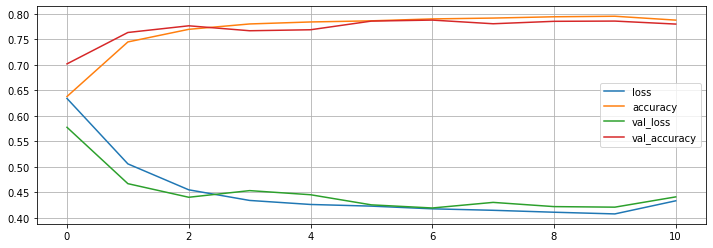

In [52]:
pd.DataFrame(history_bp.history).plot(figsize=(12,4))
plt.grid(True)

### Test result

In [53]:
y_pred_NN = (model_bp.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN))
print("F1 SCore", f1_score(y_testNN, y_pred_NN, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN))

Accuracy SCore 0.7790964511717392
F1 SCore 0.7804142268459016
Precision Score 0.7858652474093478
Recall SCore 0.7790964511717392
Confusion Matrix 
 [[14342  3653]
 [ 5877 19269]]


### Tune manuale

#### 1

In [54]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model1.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history1 = model1.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=6)]
         )

Epoch 1/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6460 - accuracy: 0.6342 - val_loss: 0.5396 - val_accuracy: 0.7266
Epoch 2/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.5061 - accuracy: 0.7458 - val_loss: 0.4841 - val_accuracy: 0.7510
Epoch 3/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4423 - accuracy: 0.7780 - val_loss: 0.4361 - val_accuracy: 0.7796
Epoch 4/50
2202/2202 [==============================] - 3s 2ms/step - loss: 0.4419 - accuracy: 0.7807 - val_loss: 0.4310 - val_accuracy: 0.7824
Epoch 5/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4226 - accuracy: 0.7893 - val_loss: 0.4351 - val_accuracy: 0.7790
Epoch 6/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4141 - accuracy: 0.7936 - val_loss: 0.4435 - val_accuracy: 0.7759
Epoch 7/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4102 - accuracy: 0.7955 - val_loss: 0.4279 - val_accuracy:

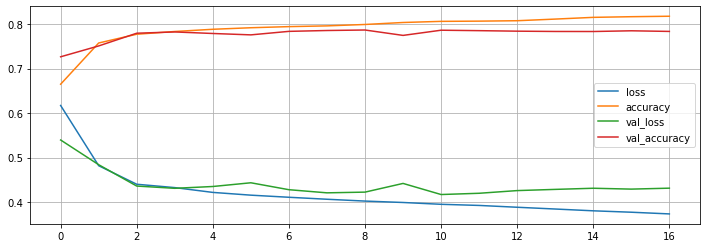

In [55]:
pd.DataFrame(history1.history).plot(figsize=(12,4))
plt.grid(True)

In [56]:
y_pred_NN1 = (model1.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN1))
print("F1 SCore", f1_score(y_testNN, y_pred_NN1, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN1, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN1, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN1))

Accuracy SCore 0.7815766903873346
F1 SCore 0.7788302455875173
Precision Score 0.7809189477262803
Recall SCore 0.7815766903873346
Confusion Matrix 
 [[12111  5884]
 [ 3539 21607]]


#### 11

In [57]:
model11 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model11.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history11 = model11.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3
         )

Epoch 1/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.6398 - accuracy: 0.6455 - val_loss: 0.6182 - val_accuracy: 0.6582
Epoch 2/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.5746 - accuracy: 0.6972 - val_loss: 0.4595 - val_accuracy: 0.7717
Epoch 3/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4537 - accuracy: 0.7726 - val_loss: 0.4349 - val_accuracy: 0.7823
Epoch 4/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4352 - accuracy: 0.7804 - val_loss: 0.4269 - val_accuracy: 0.7844
Epoch 5/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4246 - accuracy: 0.7874 - val_loss: 0.4394 - val_accuracy: 0.7796
Epoch 6/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4154 - accuracy: 0.7930 - val_loss: 0.4253 - val_accuracy: 0.7828
Epoch 7/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4124 - accuracy: 0.7951 - val_loss: 0.4323 - val_accuracy:

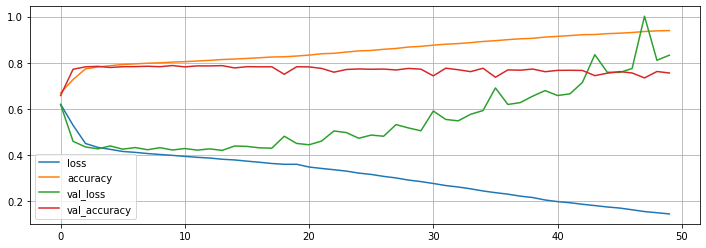

In [58]:
pd.DataFrame(history11.history).plot(figsize=(12,4))
plt.grid(True)

In [59]:
y_pred_NN11 = (model11.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN11))
print("F1 SCore", f1_score(y_testNN, y_pred_NN11, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN11, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN11, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN11))

Accuracy SCore 0.7512575044621126
F1 SCore 0.7514639379062106
Precision Score 0.7517086576076021
Recall SCore 0.7512575044621126
Confusion Matrix 
 [[12738  5257]
 [ 5474 19672]]


#### 2

In [31]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")])
model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =  ['accuracy'])
history2 = model2.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)])

Epoch 1/50
2202/2202 [==============================] - 8s 3ms/step - loss: 0.4795 - accuracy: 0.7552 - val_loss: 0.4383 - val_accuracy: 0.7811
Epoch 2/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.4272 - accuracy: 0.7890 - val_loss: 0.4200 - val_accuracy: 0.7865
Epoch 3/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.4108 - accuracy: 0.7944 - val_loss: 0.4247 - val_accuracy: 0.7857
Epoch 4/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.4053 - accuracy: 0.7985 - val_loss: 0.4163 - val_accuracy: 0.7874
Epoch 5/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.3966 - accuracy: 0.8037 - val_loss: 0.4297 - val_accuracy: 0.7777
Epoch 6/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.3881 - accuracy: 0.8081 - val_loss: 0.4175 - val_accuracy: 0.7845
Epoch 7/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.4017 - accuracy: 0.8131 - val_loss: 0.4214 - val_accuracy:

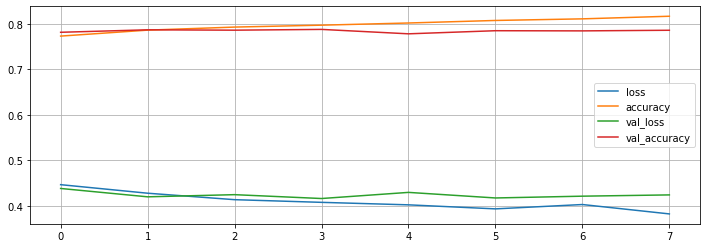

In [32]:
pd.DataFrame(history2.history).plot(figsize=(12,4))
plt.grid(True)

Accuracy SCore 0.785285459307851
F1 SCore 0.7851438507948177
Precision Score 0.7850249792438833
Recall SCore 0.785285459307851


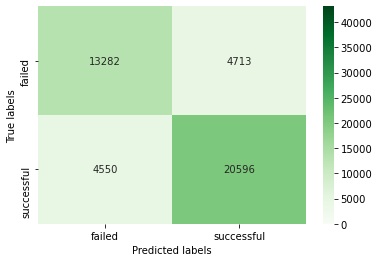

In [33]:
y_pred_NN2 = (model2.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN2))
print("F1 SCore", f1_score(y_testNN, y_pred_NN2, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN2, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN2, average='weighted'))
cm_NN = confusion_matrix(y_testNN, y_pred_NN2)
ax= plt.subplot()
sns.heatmap(cm_NN, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_NN)));
sns.heatmap(cm_NN, annot=cm_NN, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_NN)))

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

#### 22

In [75]:
model22 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model22.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history22 = model22.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3
         )

Epoch 1/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.6082 - accuracy: 0.6645 - val_loss: 1.5803 - val_accuracy: 0.6290
Epoch 2/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.6153 - accuracy: 0.6867 - val_loss: 0.5902 - val_accuracy: 0.6444
Epoch 3/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.5584 - accuracy: 0.7024 - val_loss: 0.4569 - val_accuracy: 0.7704
Epoch 4/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4498 - accuracy: 0.7748 - val_loss: 0.4584 - val_accuracy: 0.7641
Epoch 5/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4312 - accuracy: 0.7835 - val_loss: 0.4339 - val_accuracy: 0.7799
Epoch 6/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4212 - accuracy: 0.7887 - val_loss: 0.4252 - val_accuracy: 0.7833
Epoch 7/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4163 - accuracy: 0.7914 - val_loss: 0.4290 - val_accuracy:

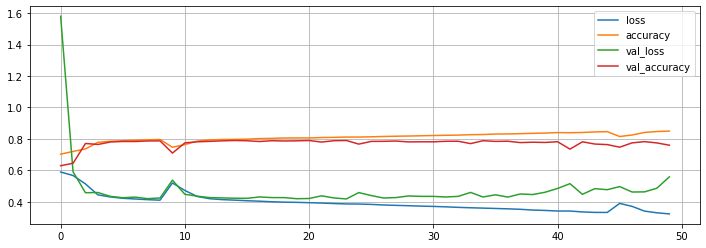

In [76]:
pd.DataFrame(history22.history).plot(figsize=(12,4))
plt.grid(True)

In [77]:
y_pred_NN22 = (model22.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN22))
print("F1 SCore", f1_score(y_testNN, y_pred_NN22, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN22, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN22, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN22))

Accuracy SCore 0.7583041654110938
F1 SCore 0.747778200052855
Precision Score 0.7676292989511411
Recall SCore 0.7583041654110938
Confusion Matrix 
 [[ 9916  8079]
 [ 2348 22798]]


#### 3

In [78]:
model3 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model3.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =  ['accuracy']
             )

history3 = model3.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2202/2202 [==============================] - 5s 2ms/step - loss: 0.4743 - accuracy: 0.7526 - val_loss: 0.4150 - val_accuracy: 0.7899
Epoch 2/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4039 - accuracy: 0.7977 - val_loss: 0.4170 - val_accuracy: 0.7894
Epoch 3/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.3764 - accuracy: 0.8155 - val_loss: 0.4202 - val_accuracy: 0.7905
Epoch 4/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.3413 - accuracy: 0.8358 - val_loss: 0.4369 - val_accuracy: 0.7883
Epoch 5/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.2937 - accuracy: 0.8608 - val_loss: 0.4658 - val_accuracy: 0.7826


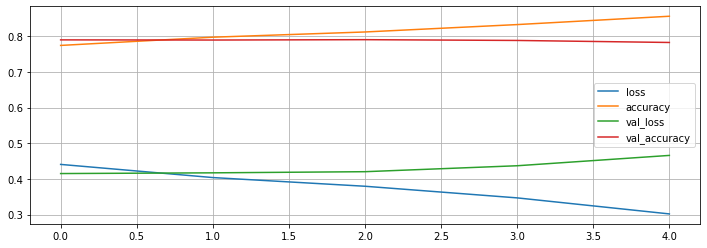

In [79]:
pd.DataFrame(history3.history).plot(figsize=(12,4))
plt.grid(True)

In [80]:
y_pred_NN3 = (model3.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN3))
print("F1 SCore", f1_score(y_testNN, y_pred_NN3, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN3, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN3, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN3))

Accuracy SCore 0.7815998701930877
F1 SCore 0.7814567353679714
Precision Score 0.7813359455686191
Recall SCore 0.7815998701930877
Confusion Matrix 
 [[13203  4792]
 [ 4630 20516]]


#### 4

In [81]:
model4 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model4.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.SGD(lr=1e-3),
              metrics =  ['accuracy']
             )

history4 = model4.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6799 - accuracy: 0.6118 - val_loss: 0.6613 - val_accuracy: 0.6171
Epoch 2/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6568 - accuracy: 0.6216 - val_loss: 0.6458 - val_accuracy: 0.6393
Epoch 3/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6436 - accuracy: 0.6447 - val_loss: 0.6349 - val_accuracy: 0.6528
Epoch 4/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6329 - accuracy: 0.6536 - val_loss: 0.6269 - val_accuracy: 0.6572
Epoch 5/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6257 - accuracy: 0.6579 - val_loss: 0.6189 - val_accuracy: 0.6626
Epoch 6/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6201 - accuracy: 0.6586 - val_loss: 0.6095 - val_accuracy: 0.6689
Epoch 7/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.6063 - accuracy: 0.6716 - val_loss: 0.5973 - val_accuracy:

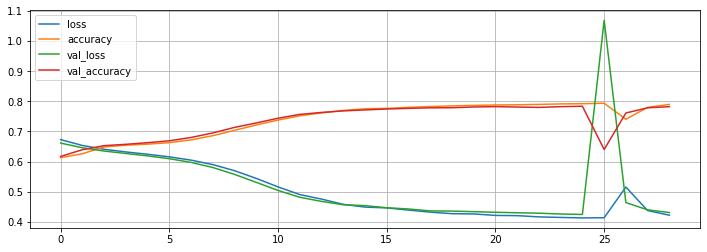

In [82]:
pd.DataFrame(history4.history).plot(figsize=(12,4))
plt.grid(True)

In [83]:
y_pred_NN4 = (model4.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN4))
print("F1 SCore", f1_score(y_testNN, y_pred_NN4, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN4, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN4, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN4))

Accuracy SCore 0.7816925894161006
F1 SCore 0.7823280086625124
Precision Score 0.7835589602837857
Recall SCore 0.7816925894161006
Confusion Matrix 
 [[13706  4289]
 [ 5129 20017]]


#### 5

In [72]:
model5 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model5.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history5 = model5.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2202/2202 [==============================] - 7s 3ms/step - loss: 0.6368 - accuracy: 0.6488 - val_loss: 0.4837 - val_accuracy: 0.7513
Epoch 2/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4705 - accuracy: 0.7674 - val_loss: 0.4683 - val_accuracy: 0.7590
Epoch 3/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4313 - accuracy: 0.7894 - val_loss: 0.4775 - val_accuracy: 0.7568
Epoch 4/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.4051 - accuracy: 0.8009 - val_loss: 0.4865 - val_accuracy: 0.7563
Epoch 5/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.3835 - accuracy: 0.8165 - val_loss: 0.4993 - val_accuracy: 0.7566
Epoch 6/50
2202/2202 [==============================] - 6s 3ms/step - loss: 0.3651 - accuracy: 0.8270 - val_loss: 0.5154 - val_accuracy: 0.7570


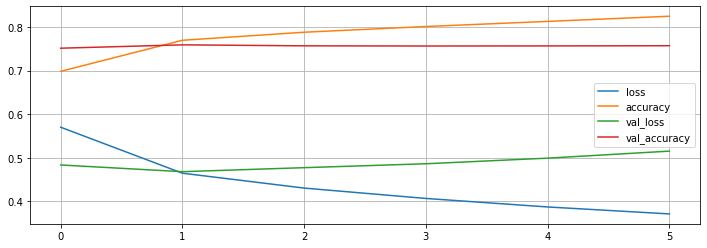

In [73]:
pd.DataFrame(history5.history).plot(figsize=(12,4))
plt.grid(True)

In [74]:
y_pred_NN4 = (model4.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN4))
print("F1 SCore", f1_score(y_testNN, y_pred_NN4, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN4, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN4, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN4))

Accuracy SCore 0.7793282492292715
F1 SCore 0.7788579348770119
Precision Score 0.7786023281015044
Recall SCore 0.7793282492292715
Confusion Matrix 
 [[12984  5011]
 [ 4509 20637]]


#### 6

In [35]:
model6 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model6.compile(loss = 'binary_crossentropy',
              optimizer = 'SGD',
              metrics =  ['accuracy']
             )

history6 = model6.fit(X_trainNN, y_trainNN,
                        epochs=50,
                        batch_size=None,
                        validation_split=0.3,
                        callbacks=[keras.callbacks.EarlyStopping(patience=3)]
         )

Epoch 1/50
2202/2202 [==============================] - 5s 2ms/step - loss: 0.5953 - accuracy: 0.6738 - val_loss: 0.4598 - val_accuracy: 0.7693
Epoch 2/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4648 - accuracy: 0.7652 - val_loss: 0.4397 - val_accuracy: 0.7771
Epoch 3/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4356 - accuracy: 0.7790 - val_loss: 0.4354 - val_accuracy: 0.7773
Epoch 4/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4574 - accuracy: 0.7723 - val_loss: 0.5508 - val_accuracy: 0.6921
Epoch 5/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4969 - accuracy: 0.7483 - val_loss: 0.4420 - val_accuracy: 0.7788
Epoch 6/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4347 - accuracy: 0.7837 - val_loss: 0.4262 - val_accuracy: 0.7854
Epoch 7/50
2202/2202 [==============================] - 4s 2ms/step - loss: 0.4165 - accuracy: 0.7935 - val_loss: 0.4335 - val_accuracy:

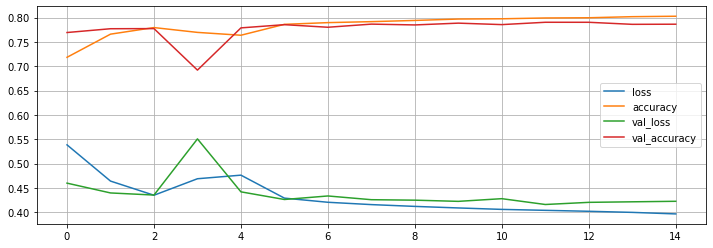

In [36]:
pd.DataFrame(history6.history).plot(figsize=(12,4))
plt.grid(True)

In [37]:
y_pred_NN6 = (model6.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN6))
print("F1 SCore", f1_score(y_testNN, y_pred_NN6, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN6, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN6, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN6))

Accuracy SCore 0.7864212697897591
F1 SCore 0.7839525877833969
Precision Score 0.7857344122362687
Recall SCore 0.7864212697897591
Confusion Matrix 
 [[12291  5704]
 [ 3510 21636]]
